In [1]:
import os
import json
import argparse
import time

import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from tensorboardX import SummaryWriter
from fastprogress import master_bar, progress_bar

# Remove warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

from config import *
from utils.graph_utils import *
from utils.google_tsp_reader import GoogleTSPReader
from utils.plot_utils import *
from models.gcn_model_modified import ResidualGatedGCNModel # SDSC8009
from utils.model_utils import *

import pandas as pd
from itertools import product

import timeit # SDSC8009

In [2]:
# Uncomment one of the below four statements to compare the performance of different aggregation functions
# agg = 'mean'
# agg = 'sum'
# agg = 'max'
agg = 'min'

china_filepath = "./data/china_concorde.txt"
china_nodes = pd.read_csv('data/china_coordinates_normalized.csv', index_col=0)[['normalized_latitude','normalized_longitude']]
china_links = pd.read_csv('data/china_links.csv', index_col=0)[['Dptstt','Arvstt']]
config_path = f"logs/result_{agg}/config.json"
config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))

Loaded logs/result_min/config.json:
{'expt_name': 'result_min', 'gpu_id': '1', 'train_filepath': './data/tsp25_train_concorde.txt', 'val_filepath': './data/tsp25_val_concorde.txt', 'test_filepath': './data/tsp25_test_concorde.txt', 'num_nodes': 25, 'num_neighbors': -1, 'node_dim': 2, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 1280, 'hidden_dim': 300, 'num_layers': 30, 'mlp_layers': 3, 'aggregation': 'min', 'max_epochs': 1500, 'val_every': 5, 'test_every': 100, 'batch_size': 20, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01}


In [3]:
# Construct the complement edge_list (SDSC8009)
station_names = china_nodes.index.values
edge_list = set()
for f,t in zip(china_links['Dptstt'],china_links['Arvstt']):
#     print(f,t)        
    f_idx = np.where(station_names==f)[0][0]
    t_idx = np.where(station_names==t)[0][0]
#     print(f_idx,t_idx)
    ft_tuple = (f_idx, t_idx)
    tf_tuple = (t_idx, f_idx)
    edge_list.add(ft_tuple)
    edge_list.add(tf_tuple)

complete_edge_list = set(product(range(25),range(25)))
complement_edge_list = complete_edge_list.difference(edge_list)

In [4]:
if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

CUDA available, using GPU ID 1


In [5]:
net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
if torch.cuda.is_available():
    net.cuda()
# print(net)

Loaded checkpoint from epoch 145
Class weights: [0.54347826 6.25      ]
Predicted normalized tour length: 4.440 
Groundtruth normalized tour length: 5.333


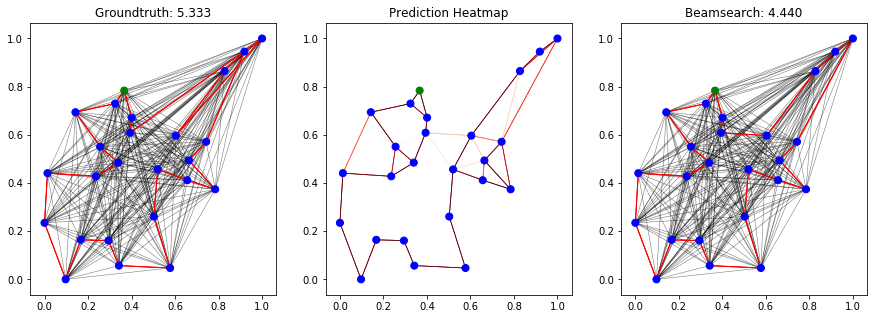

In [6]:
log_dir = f"./logs/{config.expt_name}/"
if torch.cuda.is_available():
    checkpoint = torch.load(log_dir+"best_val_checkpoint.tar")
else:
    checkpoint = torch.load(log_dir+"best_val_checkpoint.tar", map_location='cpu')
net.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.Adam(net.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
for param_group in optimizer.param_groups:
    learning_rate = param_group['lr']
print(f"Loaded checkpoint from epoch {epoch}")   
net.eval()

num_nodes = config.num_nodes
num_neighbors = config.num_neighbors
batch_size = 1
beam_size = config.beam_size
dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, batch_size, china_filepath))
batch = next(dataset)


with torch.no_grad():
    # Convert batch to torch Variables
    x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
    x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
    x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
    x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
    y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
    y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)

    # Compute class weights
    start_time = timeit.default_timer()
    edge_labels = y_edges.cpu().numpy().flatten()
    edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
    print("Class weights: {}".format(edge_cw))

    # Forward pass
    
    y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
    loss = loss.mean()

    # Restrict the search path to only existing edges
    y_preds_restricted = torch.clone(y_preds)
    null_edge = torch.zeros_like(y_preds_restricted[0,0,0])
    null_edge[0] = 0
    null_edge[1] = 0
    for e in complement_edge_list:
        y_preds_restricted[0,e[0],e[1]] = null_edge
        
    # Get batch beamsearch tour prediction
    bs_nodes_restricted = beamsearch_tour_nodes_shortest(
        y_preds_restricted, x_edges_values, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
    end_time = timeit.default_timer()
    pred_time = (end_time-start_time)

    # Compute mean tour length
    pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes_restricted)
    gt_tour_len = np.mean(batch.tour_len)
#     print("Predicted normalized tour length: {:.3f} \nGroundtruth normalized tour length: {:.3f}".format(pred_tour_len, gt_tour_len))

#     # Sanity check
#     for idx, nodes in enumerate(bs_nodes_restricted):
#         if not is_valid_tour(nodes, num_nodes):
#             print(idx, " Invalid tour: ", nodes)

#     # Plot prediction visualizations
#     plot_predictions_beamsearch(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds_restricted, bs_nodes_restricted, num_plots=batch_size)    

In [7]:
print(f"Optimal TSP path predicted by GNN with {agg} aggregation function:")
print(china_nodes.index.values[bs_nodes_restricted[0].tolist()])

print(f"\nPredicted tour length by GNN: {pred_tour_len}")

print(f"\nPrediction time by GNN: {pred_time} seconds")

Optimal TSP path predicted by GNN with min aggregation function:
['上海' '杭州' '福州' '南昌' '武汉' '长沙' '广州' '南宁' '昆明' '贵阳' '重庆' '成都' '兰州' '西安'
 '郑州' '太原' '呼和浩特' '石家庄' '北京' '哈尔滨' '长春' '沈阳' '济南' '合肥' '南京']

Predicted tour length by GNN: 4.4402875155210495

Prediction time by GNN: 3.6953833 seconds


In [8]:
print(bs_nodes_restricted)

tensor([[ 0, 13, 18,  5, 14, 23, 10,  4, 12, 20, 21, 11,  1, 19, 24,  9,  7, 17,
          2,  8, 22, 15, 16,  6,  3]], device='cuda:0')
